In [1]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    matthews_corrcoef, precision_recall_curve, roc_curve, auc
)
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from Bio.Align import substitution_matrices
from tqdm import tqdm


import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, confusion_matrix
)
from sklearn.utils import check_random_state

In [3]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from tqdm import tqdm

In [4]:


from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

# data_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/PPI/SIP-IMAGE/blosum62_fft_pca300.csv'
# data = pd.read_csv(data_path)

Mounted at /content/drive


In [5]:
current_dir = '/content/drive/MyDrive/BIO/' # Replace 'Your_Folder_Name' with the actual path
ndPath=os.path.join(current_dir)
import json
AAPHY7 = json.load(open(ndPath+"aa_phy7.txt"))

In [6]:
blosum62_raw = substitution_matrices.load("BLOSUM62")

# Amino acids in BLOSUM62
amino_acids = sorted(list(set([aa for pair in blosum62_raw.keys() for aa in pair])))

aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}
num_aa = len(amino_acids)

def encode_sequence(seq,blosum62,aa_to_index,AAPHY7):
    """
    Convert protein sequence to an N × 20 matrix using BLOSUM62 substitution scores.
    """
    seq = seq.upper()
    encoded = []
    P=[]
    # for aa in seq:
    #     if aa not in aa_to_index:
    #         # Unknown amino acid — zero vector
    #         encoded.append(np.zeros(num_aa))
    #         P.append(np.zeros(num_aa))
    #     else:
    #         idx = aa_to_index[aa]
    #         encoded.append(blosum62[idx])
    #         P.append(AAPHY7[aa])

    # return np.array(encoded),np.array(P)



    for aa in seq:
          if aa not in aa_to_index or aa not in AAPHY7:
             encoded.append(np.zeros(len(aa_to_index)))           # 20-dim
             P.append(np.zeros(len(next(iter(AAPHY7.values()))))) # 7-dim
          else:
            encoded.append(blosum62[aa_to_index[aa]])
            P.append(AAPHY7[aa])
    return np.array(encoded), np.array(P)



def extract_features(sequence,blosum62,aa_to_index):
    """
    Full pipeline: BLOSUM62 → N×20 matrix → 20×20 product → flatten → FFT → real part
    """
    # mat,P = encode_sequence(sequence,blosum62,aa_to_index)  # N x 20
    # product = np.dot(mat.T, mat)     # 20 x 20
    # flattened = product.flatten()    # 400-dim
    # fft_result = np.fft.fft(flattened).real  # Keep only real part
    # return fft_result


def extract_features(sequence, blosum62, aa_to_index, AAPHY7):
    """
    Full pipeline:
    - Encode with BLOSUM62 (N×20) and AAPHY7 (N×7)
    - Dot product: (20×20) and (7×7)
    - Flatten both → FFT → real part only
    - Return concatenated feature vector (449-dim)
    """
    max_length = max(len(seq) for seq in sequence) ### Changessssss
    mat, P = encode_sequence(sequence, blosum62, aa_to_index, AAPHY7)

    # BLOSUM62 path
    product_blosum = np.dot(mat.T, mat)             # 20×20
    flat_blosum = product_blosum.flatten()          # 400-dim
    fft_blosum = np.fft.fft(flat_blosum).real       # real part only

    # AAPHY7 path
    product_phy = np.dot(P.T, P)                    # 7×7
    flat_phy = product_phy.flatten()                # 49-dim
    fft_phy = np.fft.fft(flat_phy).real             # real part only

    # Final concatenated feature vector
    return np.concatenate([fft_blosum, fft_phy])    # 449-dim total


In [7]:



# -------------------------- Class Definition --------------------------
class RandomProjectionEnsembleClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, B1=10, B2=30, k_range=range(1, 41, 3), q_dim=100, random_state=None):
        self.B1 = B1
        self.B2 = B2
        self.k_range = k_range
        self.q_dim = q_dim
        self.random_state = check_random_state(random_state)
        self.selected_projections = []
        self.selected_classifiers = []

    def _generate_projection_matrix(self, n_features, q_dim):
        R = self.random_state.choice([-1, 1], size=(q_dim, n_features)).astype(np.float32)
        R = R / np.linalg.norm(R, axis=1, keepdims=True)
        return R

    def _evaluate_projection(self, G, y, R):
        projected_G = G @ R.T
        best_score, best_k = -1, None
        for k in self.k_range:
            loo = LeaveOneOut()
            preds = []
            for train_idx, test_idx in loo.split(projected_G):
                X_train, X_test = projected_G[train_idx], projected_G[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                clf = KNeighborsClassifier(n_neighbors=k)
                clf.fit(X_train, y_train)
                preds.append(clf.predict(X_test)[0])
            acc = accuracy_score(y, preds)
            if acc > best_score:
                best_score = acc
                best_k = k
        return best_score, best_k

    def fit(self, X, y):
        self.selected_projections = []
        self.selected_classifiers = []
        n_samples, n_features = X.shape

        candidate_projections = []
        candidate_scores = []
        candidate_classifiers = []

        for _ in tqdm(range(self.B2), desc="Generating projection pool"):
            R = self._generate_projection_matrix(n_features, self.q_dim)
            score, best_k = self._evaluate_projection(X, y, R)
            candidate_projections.append(R)
            candidate_scores.append(score)

            projected_X = X @ R.T
            clf = KNeighborsClassifier(n_neighbors=best_k)
            clf.fit(projected_X, y)
            candidate_classifiers.append(clf)

        top_indices = np.argsort(candidate_scores)[-self.B1:]
        for idx in top_indices:
            self.selected_projections.append(candidate_projections[idx])
            self.selected_classifiers.append(candidate_classifiers[idx])

    def predict(self, X):
        all_preds = []
        for R, clf in zip(self.selected_projections, self.selected_classifiers):
            proj_X = X @ R.T
            all_preds.append(clf.predict(proj_X))
        all_preds = np.array(all_preds)
        final_preds = [np.argmax(np.bincount(all_preds[:, i])) for i in range(X.shape[0])]
        return np.array(final_preds)

    def predict_proba(self, X):
        all_probs = []
        for R, clf in zip(self.selected_projections, self.selected_classifiers):
            proj_X = X @ R.T
            prob = clf.predict_proba(proj_X)
            all_probs.append(prob)
        avg_probs = np.mean(np.stack(all_probs), axis=0)
        return avg_probs[:, 1]  # Return probability of positive class

# -------------------------- Evaluation Function --------------------------
def evaluate_classifier_performance(y_true, y_pred, y_prob, name="Classifier"):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_prob)
    auprc = average_precision_score(y_true, y_prob)
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"\n{name} Results:")
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  F1 Score  : {f1:.4f}")
    print(f"  AUC-ROC   : {auc_roc:.4f}")
    print(f"  AUPRC     : {auprc:.4f}")
    print(f"  MCC       : {mcc:.4f}")
    return auc_roc, auprc


# -------------------------- Plot Functions --------------------------
def plot_roc_curves(y_test, prob_dict, title='ROC Curve Comparison'):
    plt.figure(figsize=(8, 6))
    for name, y_prob in prob_dict.items():
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_pr_curves(y_test, prob_dict, title='Precision-Recall Curve Comparison'):
    plt.figure(figsize=(8, 6))
    for name, y_prob in prob_dict.items():
        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        ap_score = average_precision_score(y_test, y_prob)
        plt.plot(recall, precision, label=f'{name} (AUPRC = {ap_score:.3f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()



In [8]:
def GenData(datapath,nc,r):

    # datapath='./data/'
    file_path = f'{datapath}final_human_df.csv'
    df = pd.read_csv(file_path)

    # Sample positive and negative sequences


    pos_d = df[df['Label'] == 1]
    neg_d = df[df['Label'] == 0]
    posn = len(pos_d['sequence'].tolist())
    negn =  len(neg_d['sequence'].tolist())
    print(f'Total Pos={posn}, Neg = {negn}')
    pos_df = df[df['Label'] == 1].sample(n=nc, random_state=42)
    neg_df = df[df['Label'] == 0].sample(n=nc*r, random_state=42)

    # print(f"POS: {len(pos_df['sequence'].tolist())}, Neg: {len(neg_df['sequence'].tolist())}")
    combined_df = pd.concat([pos_df, neg_df]).reset_index(drop=True)

    # Load BLOSUM62 substitution matrix
    blosum62_raw = substitution_matrices.load("BLOSUM62")

    # Amino acids in BLOSUM62
    amino_acids = sorted(list(set([aa for pair in blosum62_raw.keys() for aa in pair])))

    aa_to_index = {aa: i for i, aa in enumerate(amino_acids)}
    num_aa = len(amino_acids)



    # Create full BLOSUM62 matrix (symmetric)
    blosum62 = np.zeros((num_aa, num_aa))
    for (aa1, aa2), score in blosum62_raw.items():
        i, j = aa_to_index[aa1], aa_to_index[aa2]
        blosum62[i, j] = score
        blosum62[j, i] = score


    # Normalize BLOSUM62
    blosum62 = (blosum62 - np.mean(blosum62)) / np.std(blosum62)

    # Extract features from all sequences
    features = []

    labels = []

    for _, row in tqdm(combined_df.iterrows(), total=len(combined_df)):
        seq = row['sequence']
        label = row['Label']
        feature_vec = extract_features(seq,blosum62,aa_to_index,AAPHY7)  #Changess
        features.append(feature_vec)
        labels.append(label)

    features = np.array(features)
    labels = np.array(labels)
    print(features.shape)
    return features,labels

In [9]:
# Apply PCA to reduce to 300 dimensions
def feature_extraction(features,labels,datapath,ncomponents):
    pca = PCA(n_components=ncomponents)
    reduced_features = pca.fit_transform(features)

    # Create final DataFrame
    final_df = pd.DataFrame(reduced_features)
    final_df['Label'] = labels

    # Save features
    final_df.to_csv(f'{datapath}blosum62_fft_pca{ncomponents}.csv', index=False)
    print(f"Feature extraction complete and saved  at {datapath}")

In [10]:
datapath='/content/drive/MyDrive/BIO/'
nc=3617;
r=1;ncomponents=300
FeatureD,labelD=GenData(datapath,nc,r)
feature_extraction(FeatureD,labelD,datapath,ncomponents)

Total Pos=3617, Neg = 12797


100%|██████████| 7234/7234 [00:25<00:00, 279.67it/s]


(7234, 625)
Feature extraction complete and saved  at /content/drive/MyDrive/BIO/


In [11]:
# -------------------------- Load and Prepare Data --------------------------
data_path='/content/drive/MyDrive/BIO/'
ncomponents = 300
data_file_path = f'{data_path}blosum62_fft_pca{ncomponents}.csv'

data = pd.read_csv(data_file_path)
XX = data.drop('Label', axis=1).values
y = data['Label'].values

scaler = StandardScaler()
X = scaler.fit_transform(XX)

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y)
print(XX.shape)

(7234, 300)



RF Results:
  Accuracy  : 0.6158
  F1 Score  : 0.6085
  AUC-ROC   : 0.6539
  AUPRC     : 0.6276
  MCC       : 0.2316


Generating projection pool: 100%|██████████| 30/30 [3:16:27<00:00, 392.90s/it]



RPC Results:
  Accuracy  : 0.5853
  F1 Score  : 0.5215
  AUC-ROC   : 0.6107
  AUPRC     : 0.6060
  MCC       : 0.1769

SVM Results:
  Accuracy  : 0.6178
  F1 Score  : 0.6157
  AUC-ROC   : 0.6627
  AUPRC     : 0.6425
  MCC       : 0.2357

RF Results:
  Accuracy  : 0.6158
  F1 Score  : 0.6085
  AUC-ROC   : 0.6539
  AUPRC     : 0.6276
  MCC       : 0.2316


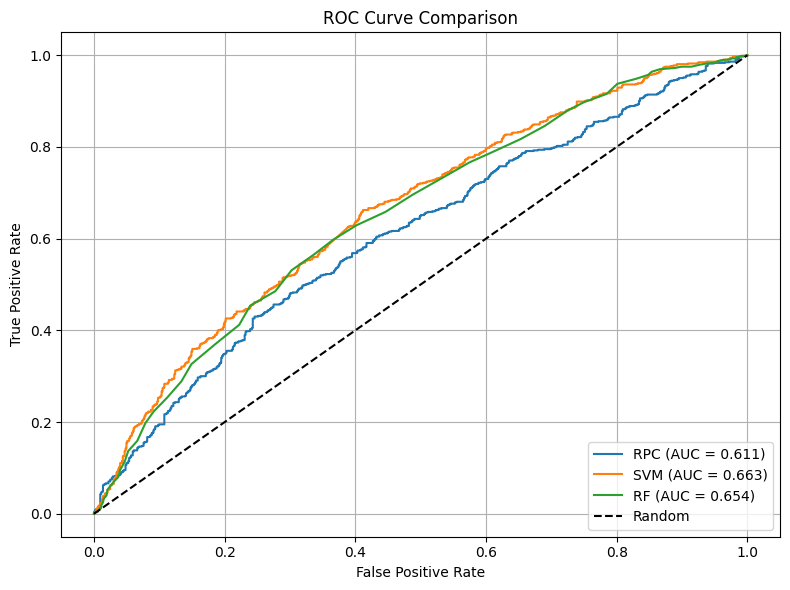

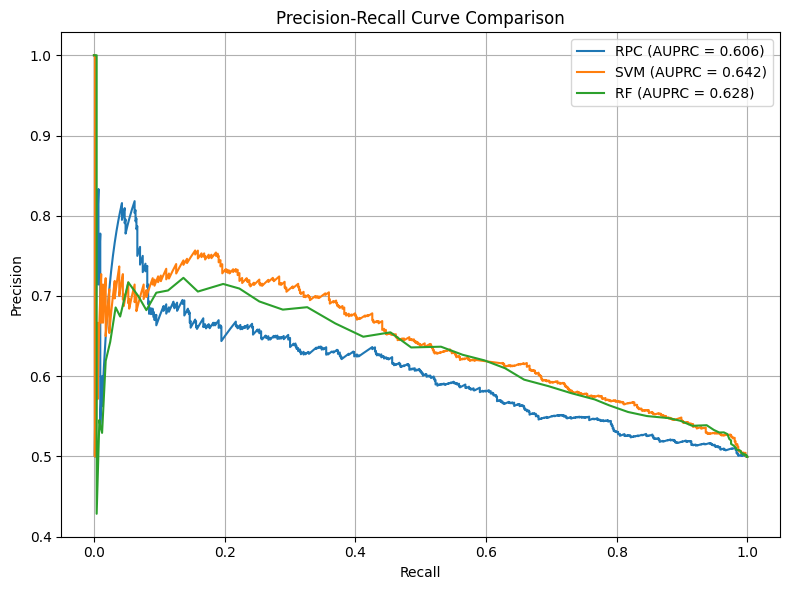

In [12]:

# -------------------------- Classifier Training --------------------------
# RF
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]
evaluate_classifier_performance(y_test, y_pred_rf, y_prob_rf, name="RF")

# RPC
rpc = RandomProjectionEnsembleClassifier(B1=10, B2=30, q_dim=100, random_state=42)
rpc.fit(X_train, y_train)
y_pred_rpc = rpc.predict(X_test)
y_prob_rpc = rpc.predict_proba(X_test)

# SVM
svm = SVC(probability=True, kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
y_prob_svm = svm.predict_proba(X_test)[:, 1]



# -------------------------- Evaluation --------------------------
evaluate_classifier_performance(y_test, y_pred_rpc, y_prob_rpc, name="RPC")
evaluate_classifier_performance(y_test, y_pred_svm, y_prob_svm, name="SVM")
evaluate_classifier_performance(y_test, y_pred_rf, y_prob_rf, name="RF")


# -------------------------- Plot All Curves --------------------------
prob_dict = {
    'RPC': y_prob_rpc,
    'SVM': y_prob_svm,
    'RF': y_prob_rf
}

plot_roc_curves(y_test, prob_dict)
plot_pr_curves(y_test, prob_dict)
